Extra Credit Assignment :  Complete this Notebook to implement a DCGAN similar to what is described in the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al. (2016).https://arxiv.org/abs/1511.06434v2  

General guidelines
1. MAKE A COPY OF THIS NOTEBOOK TEMPLATE TO YOUR OWN DRIVE BEFORE REVISING. You can download your version of the notebook and submit it to CANVAS as a .ipynb notebook file
2. You will be using a celebrity faces dataset as input from kaggle and import code for this dataset is provided below
3. Do not exceed 8 epochs as this will increase the runtime beyond what is reasonable for extra credit


###  Imports

In [1]:
# All imports

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from PIL import Image

### Discriminator module

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()  # Output: Real or Fake probability
        )

    def forward(self, x):
        return self.net(x)


### Generator Module

In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            nn.ConvTranspose2d(channels_noise, features_g * 16, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output: Image with values in range [-1, 1]
        )

    def forward(self, x):
        return self.net(x)


### Hyperparameters

In [4]:
# Using EPOCH size as 7
# Using CPU instead of GPU for training and generating since we don't have heavy GPUs available
# All hyperparams and defining all constants at one place
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0002
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 256
NUM_EPOCHS = 7
FEATURES_DISC = 64
FEATURES_GEN = 64
NUMBER_OF_IMAGES = 8


### Data-Loading and Image Transforms

In [5]:
destination_path = './img_align_celeba'

IMAGE_SIZE = (64, 64)
CHANNELS_IMG = 3
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC), # Resize images to (64, 64)
    transforms.ToTensor(),            # Convert image to tensor with range [0, 1]
    transforms.Normalize(
        mean=[0.5 for _ in range(CHANNELS_IMG)],  # Normalize with mean 0.5
        std=[0.5 for _ in range(CHANNELS_IMG)]    # Normalize with std 0.5
    )
])


# Root path to the extracted directory
dataset = datasets.ImageFolder(root='./img_align_celeba', transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=6,
    pin_memory=True
)

### Define Losses

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCELoss()(real_output, torch.ones_like(real_output))  # Real images -> 1
    fake_loss = nn.BCELoss()(fake_output, torch.zeros_like(fake_output))  # Fake images -> 0
    return real_loss + fake_loss

def generator_loss(fake_output):
    return nn.BCELoss()(fake_output, torch.ones_like(fake_output))  # Fake images -> 1


### Define Training Process

#### Seed the randomizer

In [7]:
from torch.utils.data import random_split, DataLoader

# Spliting train/test data in split of train-test as 80-20
train_size = int(0.8 * len(dataset))  # 80% train
test_size = len(dataset) - train_size

# Spliting the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the sizes of datasets
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")


Training set size: 162079
Test set size: 40520


In [8]:
generator = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))


In [9]:
def train_step(images, generator, discriminator, gen_optimizer, disc_optimizer, criterion, noise_dim, device):
    batch_size = images.size(0)

    # Training Discriminator and calculating loss
    noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
    fake_images = generator(noise)
    real_output = discriminator(images).view(-1)
    fake_output = discriminator(fake_images.detach()).view(-1)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    disc_optimizer.zero_grad()
    disc_loss.backward()
    disc_optimizer.step()

    # Training Generator and calculating loss
    fake_output = discriminator(fake_images).view(-1)
    gen_loss = generator_loss(fake_output)
    
    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()

    # Returning loss for each dataset
    return disc_loss.item(), gen_loss.item()

In [10]:
def train(dataloader, epochs, generator, discriminator, gen_optimizer, disc_optimizer, criterion, noise_dim, device):
    for d_iter in range(5):  # Update discriminator 5 times
     discriminator.train()
    generator.train()
    for epoch in range(epochs):
        for batch_idx, (real, _) in enumerate(dataloader):
            real = real.to(device)
            # Training and calculating the loss at each step
            d_loss, g_loss = train_step(real, generator, discriminator, gen_optimizer, disc_optimizer, criterion, noise_dim, device)
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")


In [11]:
# Training and Results

In [ ]:
print(f"Total dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

#Training and calculating the loss at each step
train(dataloader, NUM_EPOCHS, generator, discriminator, gen_optimizer, disc_optimizer, nn.BCELoss(), NOISE_DIM, device)
display_image(generator, NOISE_DIM, device)


Total dataset size: 202599
Number of batches: 1583
Epoch [0/7] Batch 0 | D Loss: 1.5603 | G Loss: 2.4134
Epoch [0/7] Batch 1 | D Loss: 2.7383 | G Loss: 2.7197
Epoch [0/7] Batch 2 | D Loss: 2.0167 | G Loss: 4.2341
Epoch [0/7] Batch 3 | D Loss: 1.0225 | G Loss: 5.5040
Epoch [0/7] Batch 4 | D Loss: 0.9552 | G Loss: 6.1172
Epoch [0/7] Batch 5 | D Loss: 0.7621 | G Loss: 6.7352
Epoch [0/7] Batch 6 | D Loss: 0.6736 | G Loss: 6.4996
Epoch [0/7] Batch 7 | D Loss: 0.6187 | G Loss: 6.8174
Epoch [0/7] Batch 8 | D Loss: 0.5244 | G Loss: 7.8473
Epoch [0/7] Batch 9 | D Loss: 0.3668 | G Loss: 6.5318
Epoch [0/7] Batch 10 | D Loss: 0.6226 | G Loss: 9.4699


In [ ]:
### Results

In [ ]:
def display_image(generator, noise_dim, device):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(NUMBER_OF_IMAGES, noise_dim, 1, 1).to(device)
        # Generating the images using the dataset
        fake_images = generator(noise).cpu()
        # Displaying the generated images in a grid format 8*8(64 images) grid
        grid = torchvision.utils.make_grid(fake_images, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()



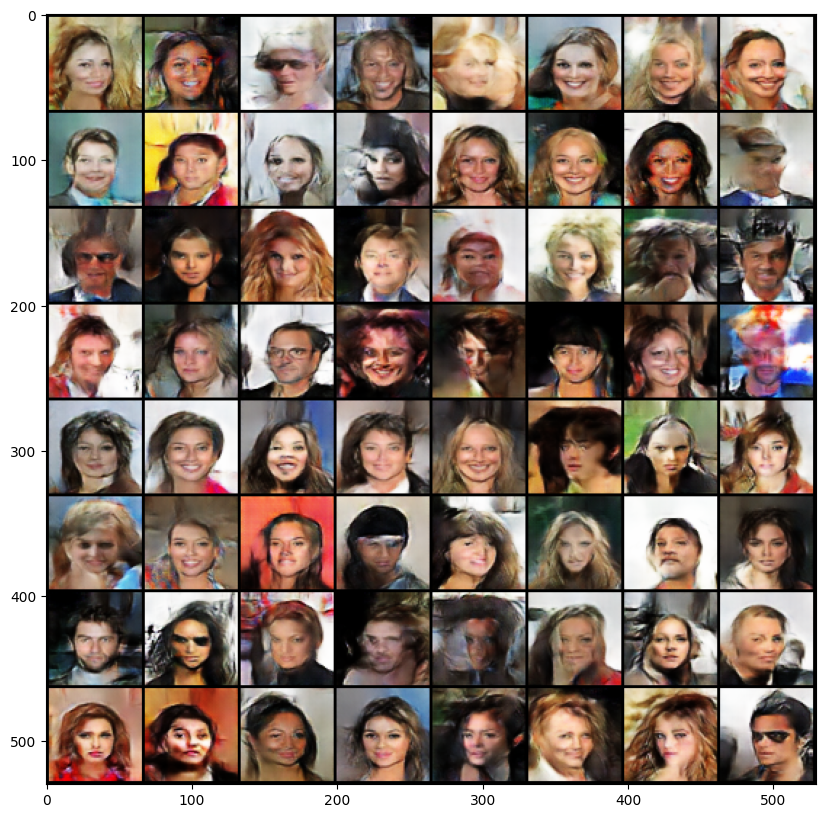

In [17]:
display_image(generator, NOISE_DIM, device)

In [ ]:
# The above is the 64 images generated using DCGAN
# Used 80-20 split as train-test split to train the model
# Used 7 as EPOCH value using local CPU for training the model